# Imports #

In [104]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import reedsolo as rs

# Functions #

In [105]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.cvtColor(cv2.imread(os.path.join(folder,filename)), cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append(img)
    return images

In [106]:
def plot(image):
    plt.imshow(image,cmap='gray', vmin=0, vmax=255)
    plt.axis('off')  # Turn off axis

In [107]:
def plot_all(images):
    size = math.ceil(math.sqrt(len(images)))
    fig, axs = plt.subplots(size, size, figsize=(15, 10))
    for i in range(size):
        for j in range(size):
            if i * size + j < len(images):
                axs[i, j].imshow(images[i * size + j], cmap='gray')
                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')
    plt.show()

In [108]:
def equalize_histogram(image):
    if any(np.unique(image) >= 127) and any(np.unique(image) < 127):
        return image
    return cv2.threshold(cv2.equalizeHist(image), 127, 255, cv2.THRESH_BINARY)[1]

In [109]:
def detect_inversion(image):
    if image.mean() < 115:
        return cv2.bitwise_not(image)
    return image

In [110]:
# Find tilting of the image and rotate it to be straight on a white background
def check_tilt(image):
    angle = find_angle(image)
    if abs(angle) < 5:
        # No tilting / slight tilting can be tolerated
        return image
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), borderValue=255)
    return np.uint8(image)

In [111]:
# find the angle of rotation of the qr code, it may be slightly tilted
def find_angle(image):
    edges = cv2.Canny(np.uint8(image), 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 70)
    
    angles = []
    angle = 0
    if lines is not None and len(lines) > 130:
        for line in lines:
            for rho, theta in line:
                if np.pi / 4 < theta < 3 * np.pi / 4:
                    angles.append(np.rad2deg(theta - np.pi / 2))
                elif np.pi / 4 < -theta < 3 * np.pi / 4:
                    angles.append(np.rad2deg(theta + np.pi / 2))

    if len(angles) > 0:
        angle = np.median(angles) - 2
    return angle

In [112]:
def remove_salt_and_pepper(image, factor):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    ms = np.log(np.abs(fshift) + 1)
    average = np.average(ms)

    if average > factor:
        return try_lowpass(image, 26, True)
    return image

In [113]:
# Export processed image into a file in test_outputs folder
def export_image(image, path):
    cv2.imwrite(path, image)

In [114]:
def fata7i_ya_warda(image, structuring_element_size, iterations=1, structuring_element=cv2.MORPH_RECT):
    se_rect = cv2.getStructuringElement(structuring_element, structuring_element_size)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, se_rect, iterations=iterations)

In [115]:
def afeli_ya_warda(image, structuring_element_size, iterations=1):
    se_rect = cv2.getStructuringElement(cv2.MORPH_RECT, structuring_element_size)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, se_rect, iterations=iterations)

In [116]:
def threshold(image, factor):
    _, image = cv2.threshold(image, factor, 255, cv2.THRESH_BINARY)
    return image

In [117]:
def sharpen(image, iterations=1):
    temp_image = image
    
    kernel = np.array([[0,-1,0],
                       [-1,5,-1],
                       [0,-1,0]])
    
    for _ in range(iterations):
        temp_image = cv2.filter2D(temp_image, -1, kernel=kernel)

    return temp_image

In [118]:
def remove_anomaly_frequencies(image, factor):
    dft_image = np.fft.fft2(image)
    dft_image_shift = np.fft.fftshift(dft_image)
    magnitude_spectrum = np.log(np.abs(dft_image_shift) + 1)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    magnitude_spectrum[crow][ccol] = 0
    average = np.average(magnitude_spectrum)
    if average < 1:
        dft_image_shift[magnitude_spectrum > average + factor * 5] = 0
    else:
        dft_image_shift[magnitude_spectrum > average * factor] = 0
    return np.abs(np.fft.ifft2(dft_image_shift))

In [119]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx,cy), radius, (255,255,255), -1).astype(np.uint8)

def try_lowpass(img, limit, gaussian: bool = False):
    dft_img = np.fft.fft2(img)
    dft_img_shifted = np.fft.fftshift(dft_img)
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian): mask = cv2.GaussianBlur(mask, (21,21), 0)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    return cv2.normalize(np.abs(np.fft.ifft2(dft_img_shifted_lowpass)), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [120]:
def detect_qr_code(image):
    # white padding is added to the image to avoid the QR code to be on the edges
    image_pad = cv2.copyMakeBorder(image, 100, 100, 100, 100, cv2.BORDER_CONSTANT, value=255)
    
    # Create a copy from the image where the body of the QR code is black
    image_opened = fata7i_ya_warda(image_pad, (100, 100), 1)
    
    # Generate a white image from the image
    image_white = np.ones_like(image_pad) * 255
    
    # Detect the edges of the image
    edges = cv2.Canny(np.uint8(image_opened), 100, 200)
    
    # Make found edges perfect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
    
    # record the closest theta to 0 and pi / 2
    closest_to_0 = np.pi / 2
    closest_to_pi_2 = 0
    for line in lines:
        for rho, theta in line:
            if abs(theta) < abs(closest_to_0):
                closest_to_0 = theta
            if abs(theta - np.pi / 2) < abs(closest_to_pi_2 - np.pi / 2):
                closest_to_pi_2 = theta
    
    for line in lines:
        rho, theta = line[0]
        if abs(theta - closest_to_0) > 0.1 and abs(theta - closest_to_pi_2) > 0.1:
            continue
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1500 * (-b))
        y1 = int(y0 + 1500 * (a))
        x2 = int(x0 - 1500 * (-b))
        y2 = int(y0 - 1500 * (a))
        cv2.line(image_white, (x1, y1), (x2, y2), (0, 0, 0), 2)
        
    # Detect the corners of the QR code using Harris
    corners = cv2.cornerHarris(np.uint8(image_white), 3, 3, 0.04)
    
    # From corners, find the indexes where is white
    idx = []
    max = corners.max()
    # Loop on every pixel in corners
    for i in range(corners.shape[0]):
        for j in range(corners.shape[1]):
            # If the pixel is white and near the edge, add it to the list
            if corners[i, j] > 0.5 * max:
                idx.append((i, j))
                
    # Exclude points in idx that are close to each other and keep the nearest to the corner of the image
    idx = sorted(idx, key=lambda x: x[0])
    rows, cols = corners.shape
    corners = [idx[0]]
    for i in range(1, len(idx)):
        new = True
        for j in corners:
            if abs(idx[i][0] - j[0]) < rows / 2 and abs(idx[i][1] - j[1]) < cols / 2:
                if j[0] < rows/2 and j[1] < cols/2:
                    if idx[i][0] + idx[i][1] < j[0] + j[1]:
                        corners.remove(j)
                        corners.append(idx[i])
                elif j[0] < rows/2 and j[1] > cols/2:
                    if idx[i][0] - idx[i][1] < j[0] - j[1]:
                        corners.remove(j)
                        corners.append(idx[i])
                elif j[0] > rows/2 and j[1] < cols/2:
                    if idx[i][1] - idx[i][0] < j[1] - j[0]:
                        corners.remove(j)
                        corners.append(idx[i])
                else:
                    if idx[i][0] + idx[i][1] > j[0] + j[1]:
                        corners.remove(j)
                        corners.append(idx[i])
                new = False
                break
        if new:        
            corners.append(idx[i])
    
    # Sort the corners
    corners_temp = [(x[1], x[0]) for x in corners]
    for corner in corners_temp:
        if corner[0] < rows / 2 and corner[1] < cols / 2:
            corners[0] = corner
        elif corner[0] < rows / 2 and corner[1] > cols / 2:
            corners[1] = corner
        elif corner[0] > rows / 2 and corner[1] < cols / 2:
            corners[2] = corner
        else:
            corners[3] = corner
        
    if needs_straightening(image_white.shape, corners):
        # Calculate the transformation matrix based on the corners
        rows, cols = image_white.shape
        pts1 = np.float32(corners)
        pts2 = np.float32([[0, 0], [0, rows], [cols, 0], [cols, rows]])
        M = cv2.getPerspectiveTransform(pts1, pts2)     
        # Warp the image to straighten the QR code
        image_out = cv2.warpPerspective(image_pad, M, (cols, rows))
        # Resize the image to be same as image
        image_out = cv2.resize(image_out, (1050, 1050))
        # Fix the stretching of the image
        image_out = fix_stretching(image_out)
    else:
        # Resize the image to be same as image
        image_out = cv2.resize(image, (1050, 1050))
    
    return image_out

In [121]:
def capture(image):
    rows , cols = image.shape
    
    # Perform closing operation to remove noise
    image_temp = afeli_ya_warda(image, (10, 10), 1)
    # loop over all black pixels and record the minimum distance from any of the 4 borders
    top = rows
    bottom = 0
    left = cols
    right = 0
    for i in range(rows):
        for j in range(cols):
            if image_temp[i, j] < 127:
                top = min(top, i)
                bottom = bottom if bottom > i else i
                left = min(left, j)
                right = right if right > j else j

    if bottom - top > 0.8 * rows or right - left > 0.8 * cols:
        pass
    else:
        # crop the image
        image = image[top-30:bottom+30, left-30:right+30]
    # resize the image to the original
    image = cv2.resize(image, (cols, rows))
    
    return image
    

In [122]:
def needs_straightening(shape, corners):
    if shape[0] < 1200 or shape[1] < 1200:
        return True
    
    farthest_low_index = max(corners[0][0], corners[0][1], corners[1][0], corners[2][1])
    farthest_high_index = min(corners[1][1], corners[2][0], corners[3][0], corners[3][1])
    if farthest_low_index > 200 or farthest_high_index < shape[1] - 200:
        return True
    
    return False

In [123]:
def fix_stretching(image):
    rows, cols = image.shape
    locator_edge_size = int(rows / 3)
    
    # Horizontal Stretching
    image_padded = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=255)
    image_d1 = cv2.dilate(image_padded, np.ones((20,1), np.uint8), iterations=1)
    image_d1 = cv2.dilate(image_d1, np.ones((1,locator_edge_size + 1), np.uint8), iterations=1)
    image_t = threshold(image_d1, 127)
    
    _, _, _, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(image_t), connectivity=8)
    centroids = centroids[1:]
    
    left_padding = 0
    right_padding = 0
    for centroid in centroids:
        if centroid[0] < cols / 4:
            right_padding = max(right_padding ,find_max_width(image_t) * rows / locator_edge_size)
        elif centroid[0] > 3 * cols / 4:
            left_padding = max(left_padding, find_max_width(image_t) * rows / locator_edge_size)
    
    image_p = cv2.copyMakeBorder(image, 0, 0, int(left_padding), int(right_padding), cv2.BORDER_CONSTANT, value=255)
    image = cv2.resize(image_p, (1050, 1050), interpolation=cv2.INTER_AREA)
    
    # Vertical Stretching
    image_padded = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=255)
    image_d1 = cv2.dilate(image_padded, np.ones((1,20), np.uint8), iterations=1)
    image_d1 = cv2.dilate(image_d1, np.ones((locator_edge_size + 1,1), np.uint8), iterations=1)
    image_t = threshold(image_d1, 127)
    
    _, _, _, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(image_t), connectivity=8)
    centroids = centroids[1:]
    
    top_padding = 0
    bottom_padding = 0
    for centroid in centroids:
        if centroid[1] < rows / 4:
            bottom_padding = max(bottom_padding, find_max_height(image_t) * cols / locator_edge_size)
        elif centroid[1] > 3 * rows / 4:
            top_padding = max(top_padding, find_max_height(image_t) * cols / locator_edge_size)
            
    image_p = cv2.copyMakeBorder(image, int(top_padding), int(bottom_padding), 0, 0, cv2.BORDER_CONSTANT, value=255)
    image_out = cv2.resize(image_p, (1050, 1050), interpolation=cv2.INTER_AREA)
    
    return image_out

In [124]:
# find the largest width of the black area
def find_max_width(image):
    rows, cols = image.shape
    max_width = 0
    for i in range(rows):
        width = 0
        for j in range(cols):
            if image[i, j] < 127:
                width += 1
            else:
                max_width = max(max_width, width)
                width = 0
        max_width = max(max_width, width)
    return max_width

In [125]:
def find_max_height(image):
    rows, cols = image.shape
    max_height = 0
    for i in range(cols):
        height = 0
        for j in range(rows):
            if image[j, i] < 127:
                height += 1
            else:
                max_height = max(max_height, height)
                height = 0
        max_height = max(max_height, height)
    return max_height

In [126]:
def check_pattern(cells):
    """
    Check if the mean value of each cell in cells is within a tolerance of the corresponding value in the pattern.
    """
    pattern = [0, 255, 0, 0, 0, 255, 0]  # 1:1:3:1:1 pattern
    tolerance = 100
    results = [abs(int(np.mean(cell)) - pat) <= tolerance for cell, pat in zip(cells, pattern)]
    return all(results)

def rotate_image(image, degrees):
    return np.rot90(image, degrees // 90)

def check_valid_format(og, qr_cells, grid_cells_num, grid_cell_size):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    ecl = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-2:grid_cells_num, 8]]
    mask = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-3:grid_cells_num-6:-1, 8]]
    fec = np.concatenate(([qr_cells_numeric[grid_cells_num-6, 8]], [qr_cells_numeric[grid_cells_num-7, 8]], qr_cells_numeric[8, grid_cells_num-8:grid_cells_num][::-1]))  # Reverse to get from col 20 to col 13
    fec = [int(not(c)) for c in fec]

    ecl_check = [int(not(c)) for c in qr_cells_numeric[8, :2]]
    mask_check = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    fec_check = np.concatenate(([qr_cells_numeric[8, 5]], [qr_cells_numeric[8, 7]], qr_cells_numeric[7:9,8][::-1], qr_cells_numeric[0:6,8][::-1]))
    fec_check = [int(not(c)) for c in fec_check]

    if not (ecl + mask + fec == ecl_check + mask_check + fec_check):
        revert = rotate_image(qr_cells, 270)
        return cv2.flip(og, 1).reshape((grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size)).swapaxes(1, 2)
    else:
        return qr_cells

def correct_orientation(og, qr_cells, grid_cells_num, grid_cell_size):
    """
    Correct the orientation of the QR code by checking the patterns in the corners and rotating if necessary.
    """
    # Check patterns in the corners
    bottom_right = qr_cells[grid_cells_num - 4, -7:], qr_cells[-7:, grid_cells_num-4]
    top_right = qr_cells[3, -7:], qr_cells[:7, grid_cells_num-4]
    bottom_left = qr_cells[grid_cells_num-4, :7], qr_cells[-7:, 3]


    # If the bottom right corner does not match the pattern, the QR code is in the correct orientation
    if not any(map(check_pattern, bottom_right)):
        return qr_cells

    # If all corners match the pattern, rotate 180 degrees
    if all(map(check_pattern, top_right + bottom_left)):
        return rotate_image(qr_cells, 180)

    # If the top right and bottom right corners match the pattern, rotate 270 degrees
    if all(map(check_pattern, top_right + bottom_right)):
        rotated = rotate_image(qr_cells, 90)
        return check_valid_format(og, rotated, grid_cells_num, grid_cell_size)


    # If the bottom left and bottom right corners match the pattern, rotate 90 degrees
    if all(map(check_pattern, bottom_left + bottom_right)):
        return rotate_image(qr_cells, 270)

In [127]:
def calculate_hamming_distance(seq1, seq2):
    return sum(bit1 != bit2 for bit1, bit2 in zip(seq1, seq2))

def fix_format_info(format_info):
    valid_format_sequence = [
      [1,0,1,0,1,0,0,0,0,0,1,0,0,1,0], # 00 000
      [1,0,1,0,0,0,1,0,0,1,0,0,1,0,1], # 00 001
      [1,0,1,1,1,1,0,0,1,1,1,1,1,0,0], # 00 010
      [1,0,1,1,0,1,1,0,1,0,0,1,0,1,1], # 00 011
      [1,0,0,0,1,0,1,1,1,1,1,1,0,1,1], # 00 100
      [1,0,0,0,0,0,0,1,1,0,0,1,1,1,0], # 00 101
      [1,0,0,1,1,1,1,1,0,0,1,0,1,1,1], # 00 110
      [1,0,0,1,0,1,0,1,0,1,0,0,0,0,0], # 00 111

      [1,1,1,0,1,1,1,1,1,0,0,0,1,0,0], # 01 000
      [1,1,1,0,0,1,0,1,1,1,1,0,0,1,1], # 01 001
      [1,1,1,1,1,0,1,1,0,1,0,1,0,1,0], # 01 010
      [1,1,1,1,0,0,0,1,0,0,1,1,1,0,1], # 01 011
      [1,1,0,0,1,1,0,0,0,1,0,1,1,1,1], # 01 100
      [1,1,0,0,0,1,1,0,0,0,1,1,0,0,0], # 01 101
      [1,1,0,1,1,0,0,0,1,0,0,0,0,0,1], # 01 110
      [1,1,0,1,0,0,1,0,1,1,1,0,1,1,0], # 01 111

      [0,0,1,0,1,1,0,1,0,0,0,1,0,0,1], # 10 000
      [0,0,1,0,0,1,1,1,0,1,1,1,1,1,0], # 10 001
      [0,0,1,1,1,0,0,1,1,1,0,0,1,1,1], # 10 010
      [0,0,1,1,0,0,1,1,1,0,1,0,0,0,0], # 10 011
      [0,0,0,0,1,1,1,0,1,1,0,0,0,1,0], # 10 100
      [0,0,0,0,0,1,0,0,1,0,1,0,1,0,1], # 10 101
      [0,0,0,1,1,0,1,0,0,0,0,1,1,0,0], # 10 110
      [0,0,0,1,0,0,0,0,0,1,1,1,0,1,1], # 10 111

      [0,1,1,0,1,0,1,0,1,0,1,1,1,1,1], # 11 000
      [0,1,1,0,0,0,0,0,1,1,0,1,0,0,0], # 11 001
      [0,1,1,1,1,1,1,0,0,1,1,0,0,0,1], # 11 010
      [0,1,1,1,0,1,0,0,0,0,0,0,1,1,0], # 11 011
      [0,1,0,0,1,0,0,1,0,1,1,0,1,0,0], # 11 100
      [0,1,0,0,0,0,1,1,0,0,0,0,0,1,1], # 11 101
      [0,1,0,1,1,1,0,1,1,0,1,1,0,1,0], # 11 110
      [0,1,0,1,0,1,1,1,1,1,0,1,1,0,1]  # 11 111
    ]

    # Initialize min_distance with a large number and min_seq with None
    min_distance = float('inf')
    min_seq = None

    for seq in valid_format_sequence:
        # Calculate the hamming distance between format_info and seq
        distance = calculate_hamming_distance(format_info, seq)

        # If the distance is 0, then we have found an exact match
        if distance == 0:
            return seq

        # If the distance is less than min_distance, update min_distance and min_seq
        if distance < min_distance:
            min_distance = distance
            min_seq = seq

    # If no exact match was found, return the sequence with the minimum hamming distance
    format_info = min_seq
    return format_info

In [128]:
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    #------------------------new directions just dropped-----------------------#
    if (direction == UP_IRR):
        row_offsets = [0, -1, -1, -2, -2, -3, -3, -4]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_IRR):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  4]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == CCW_IRR):
        row_offsets = [0,  0, -1, -1, -2, -2, -2, -2]
        col_offsets = [0, -1,  0, -1,  0, -1, -2, -3]
    if (direction == UP_CORNER):
        row_offsets = [0, -1, -1, -2, -3, -3, -3, -3]
        col_offsets = [0,  1,  0,  1,  0,  1,  0, -1]
    if (direction == DOWN_CORNER):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  3]
        col_offsets = [0,  1, -1,  1, -1,  1,  0, -1]
    if (direction == UP_SKIP_TIM):
        row_offsets = [0, -1, -1, -3, -3, -4, -4, -5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_SKIP_TIM):
        row_offsets = [0,  1,  1,  2,  2,  4,  4,  5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_SKIP_ALIGN):
        row_offsets = [0,  0,  1,  1,  6,  6,  7,  7]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == UP_ALIGN):
        row_offsets = [0,  0, -1, -1, -2, -3, -4, -5]
        col_offsets = [0, -1,  0, -1, -1, -1, -1, -1]
    if (direction == CCW_SKIP_TIM):
        row_offsets = [0, -1, -1, -2, -2, -3, -3, -3]
        col_offsets = [0,  1,  0,  1,  0,  1,  0, -2]
    if (direction == UP_SKIP_FORMAT):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  -5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  -1]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [136]:
def bin_to_alphanum(bits):

    num = int(bits, 2)

    # This part is similar to saying that 78 = 7 * 10 + 8
    # Originally if we're encoding alpahnumeric characters for example TH (T:29, H:17)
    # We would get the binary string by converting 29 * 45 + 17 to binary

    first_num = num // 45
    first_char = ALPHANUMERIC_TABLE[first_num]

    second_num = num % 45
    second_char = ALPHANUMERIC_TABLE[second_num]

    return first_char + second_char

def decode_alphanumeric_v1():
    ans = ''
    data_string = ''

    for a, b, d in v1_data_starting_indices:
        bits = apply_mask_general(a, b, img_grid_inv, mask,  d)
        # Convert list of bits to string and concatenate to data_string
        data_string += ''.join([str(bit) for bit in bits])

    # Exclude the first 4 bits of the encoding type
    data_string = data_string[4:]
    # The length should be read in the next 9 bits
    length = int(data_string[:9], 2)

    data_string = data_string[9:]

    # Process the data 11 bits by 11 bits
    while length > 1:
        chars = bin_to_alphanum(data_string[:11])
        ans += chars
        data_string = data_string[11:]
        length -= 2

    # If the number of characters in the to be decoded string is odd, the last character is represented in 6 bits
    if length == 1:
        last_char = ALPHANUMERIC_TABLE[int(data_string[:6], 2)]
        ans += last_char

    print(f'\nDecoded string: {ans}')
    # Append it to a file
    with open('decoded.txt', 'a') as f:
        f.write(ans + '\n')

In [163]:
def decode_byte_mode_v1():
    message_bits = []
    message_bits.extend(enc_bits)
    message_bits.extend(len_bits)
    # Let me re-format this for better readability :)
    # First, let's read the data bytes, starting from the very first byte after enc and len
    byte_index = 2
    byte_stream = ''
    extracted_data_no_error_correction = ''
    for _ in range(len_int):
        start_i, start_j, dir = v1_data_starting_indices[byte_index]
        bits = apply_mask_general(start_i, start_j, img_grid_inv, mask, dir)
        bit_string = ''.join([str(bit) for bit in bits])
        extracted_data_no_error_correction += chr(int(bit_string, 2))
        byte_stream += bit_string
        message_bits.extend(bits)
        bit_string = ''.join([str(bit) for bit in bits])
        alpha_char = chr(int(bit_string, 2))
        byte_index += 1

    start_i, start_j, dir = v1_data_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_grid_inv, mask, dir)
    byte = bytes([int(byte_stream[i:i+8], 2) for i in range(0, len(byte_stream), 8)])
    message_bits.extend(bits)
    byte_index += 1

    for _ in range(25 - len_int - 1):
        start_i, start_j, dir = v1_data_starting_indices[byte_index]
        bits = apply_mask_general(start_i, start_j, img_grid_inv, mask, dir)
        message_bits.extend(bits)
        bit_string = ''.join([str(bit) for bit in bits])
        alpha_char = chr(int(bit_string, 2))
        byte_index += 1

    message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

    # Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
    rsc = rs.RSCodec(nsym=7)

    # Decode the bytes with the 7-ECC RS Codec
    try:
        message_decoded = rsc.decode(message_bytes)
        rsc.maxerrata(verbose=True)
        data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
        try:
            print(f'Data in message = "{data_bytes.decode(encoding="utf-8")}"')
            # Append it to a file
            with open('decoded.txt', 'a') as f:
                f.write(data_bytes.decode(encoding="utf-8") + '\n')
        except:
            print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
            # Append it to a file
            with open('decoded.txt', 'a') as f:
                f.write(data_bytes.decode(encoding="iso-8859-1")[:-4] + '\n')
    except rs.ReedSolomonError as e:
        # Append it to a file
        with open('decoded.txt', 'a') as f:
            f.write(extracted_data_no_error_correction + '\n')

# Load Images #

In [92]:
images = load_images_from_folder("./test-cases")

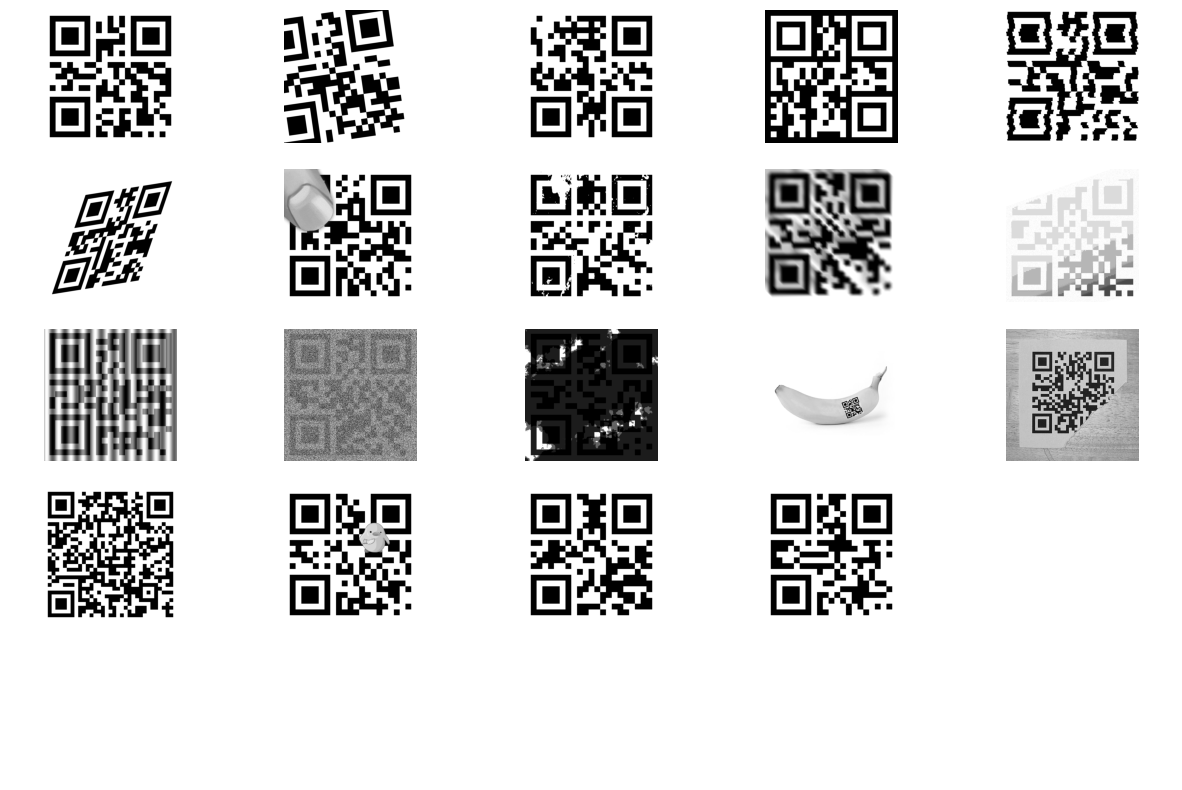

In [93]:
plt.style.use({'figure.facecolor': 'white'})
plot_all(images)

# Preprocessing #

## Histogram Equalization ##

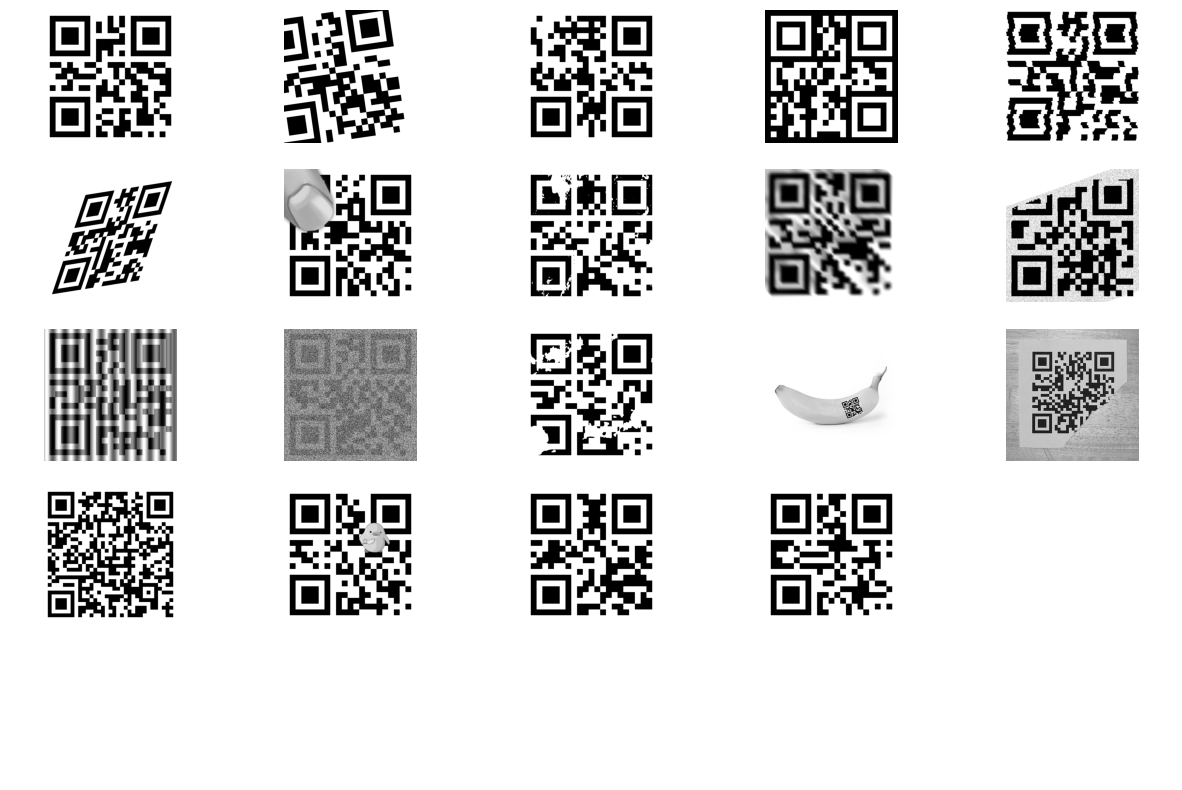

In [94]:
images_equalized = []
for image in images:
    image = equalize_histogram(np.uint8(image))
    images_equalized.append(image)
plot_all(images_equalized)

## Frequency Domain Noise ##

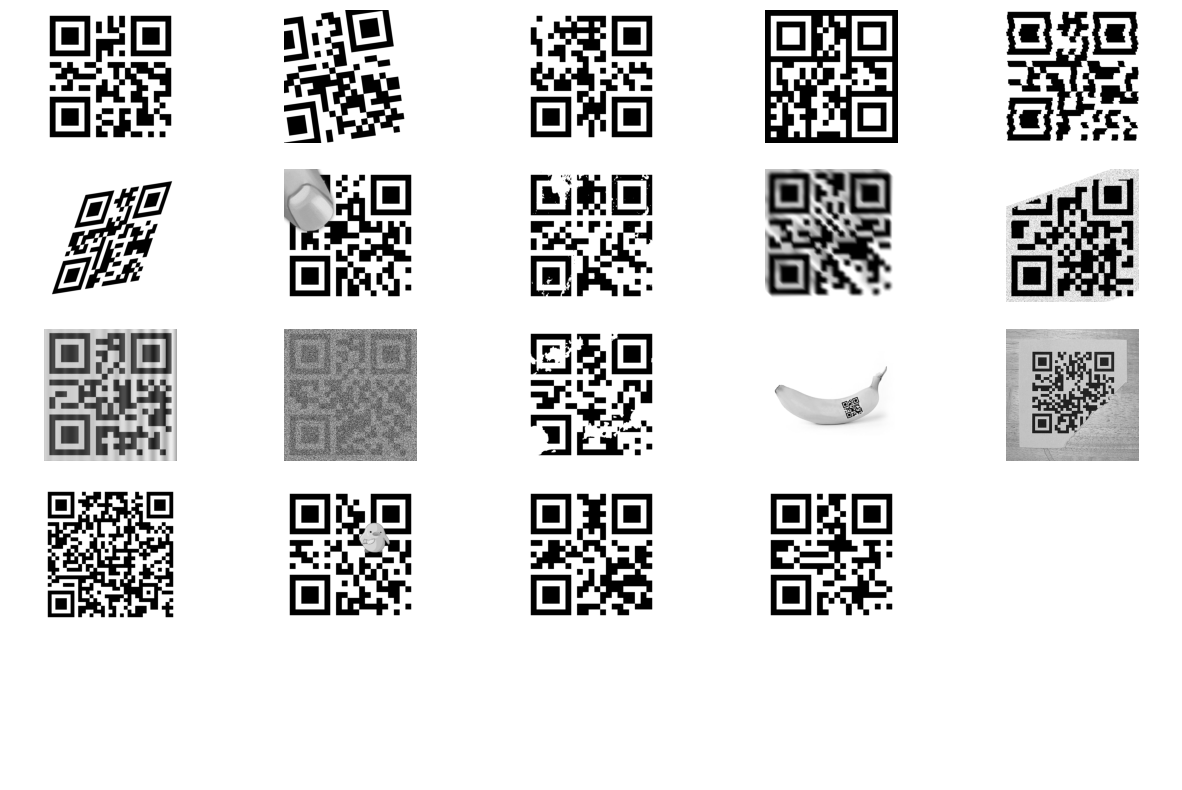

In [95]:
images_fdn = []
for image in images_equalized:
    image = remove_anomaly_frequencies(image, 3)
    images_fdn.append(image)
plot_all(images_fdn)

## Salt and Pepper Noise ##

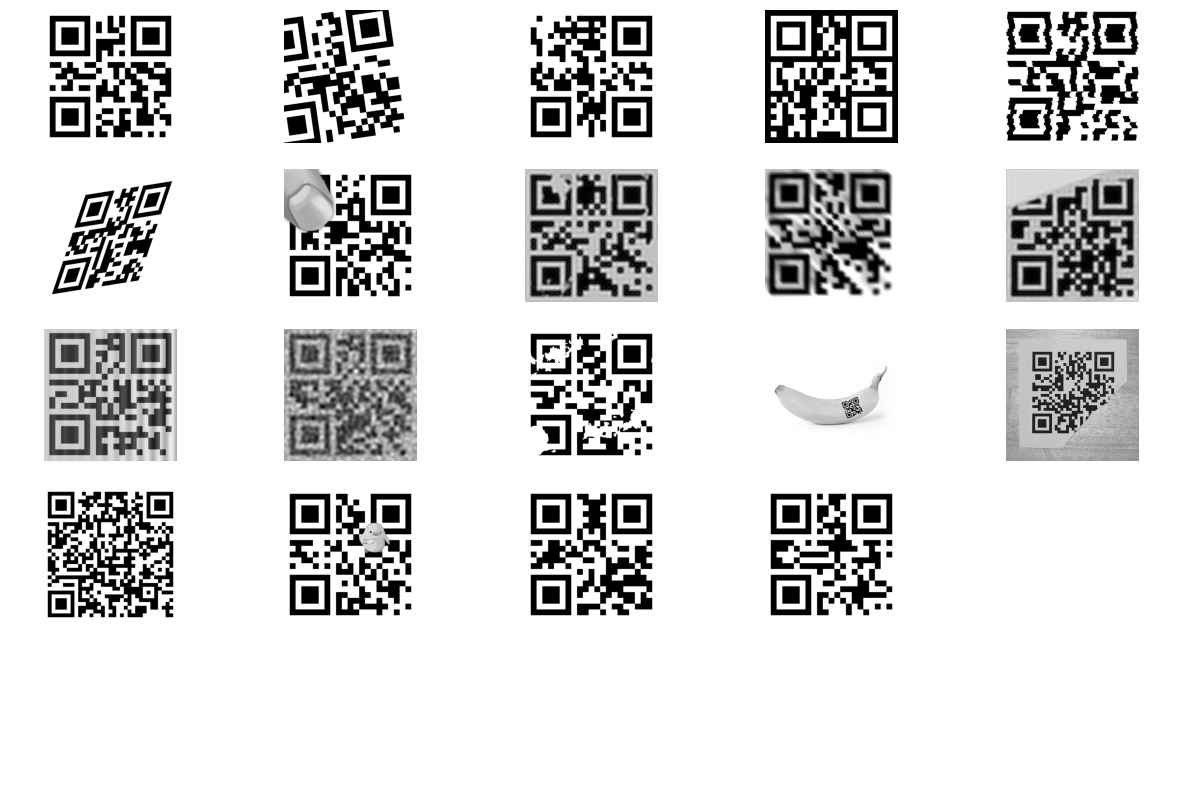

In [96]:
images_spn = []
for image in images_fdn:
    image = remove_salt_and_pepper(image, 9)
    images_spn.append(image)
plot_all(images_spn)

# Inversion

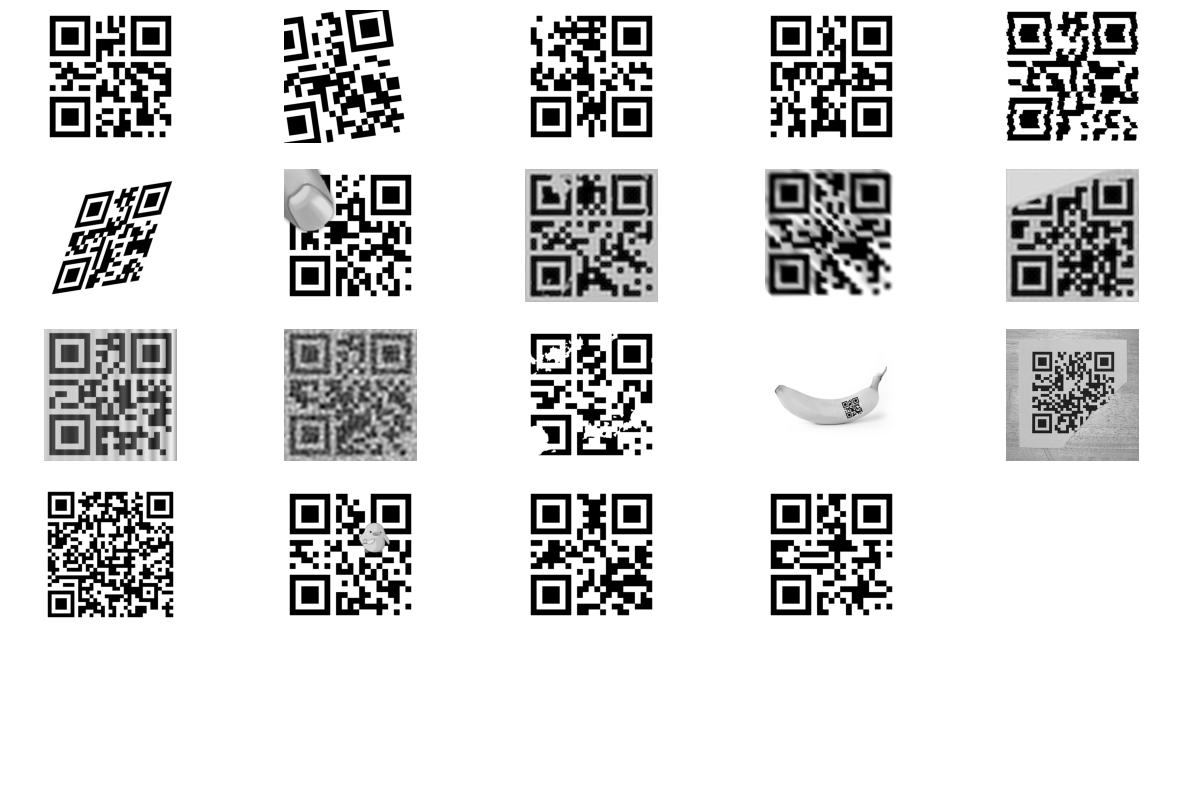

In [97]:
images_inverted = []
for image in images_spn:
    image = detect_inversion(np.uint8(image))
    images_inverted.append(image)
plot_all(images_inverted)

## Thresholding ##

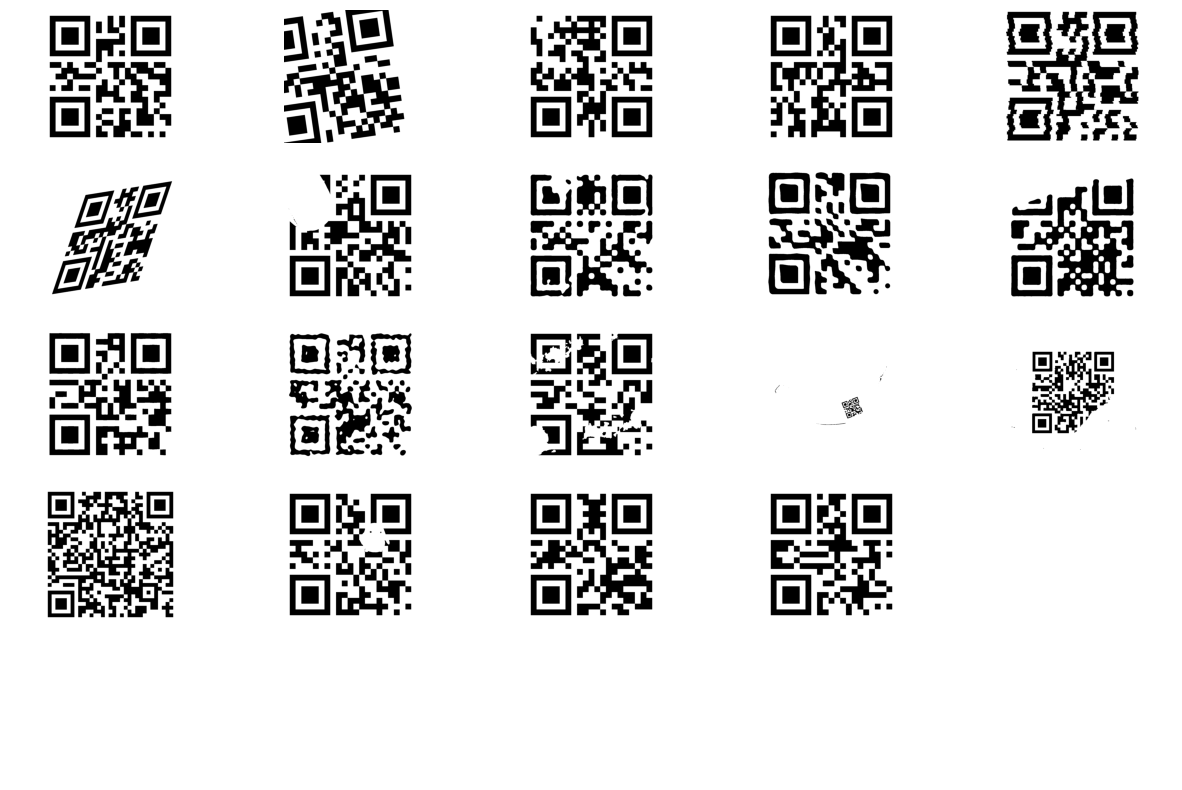

In [98]:
images_thresholded = []
for image in images_inverted:
    image = threshold(image, 100)
    images_thresholded.append(image)
plot_all(images_thresholded)

## Capturing the QR code most probable area ##

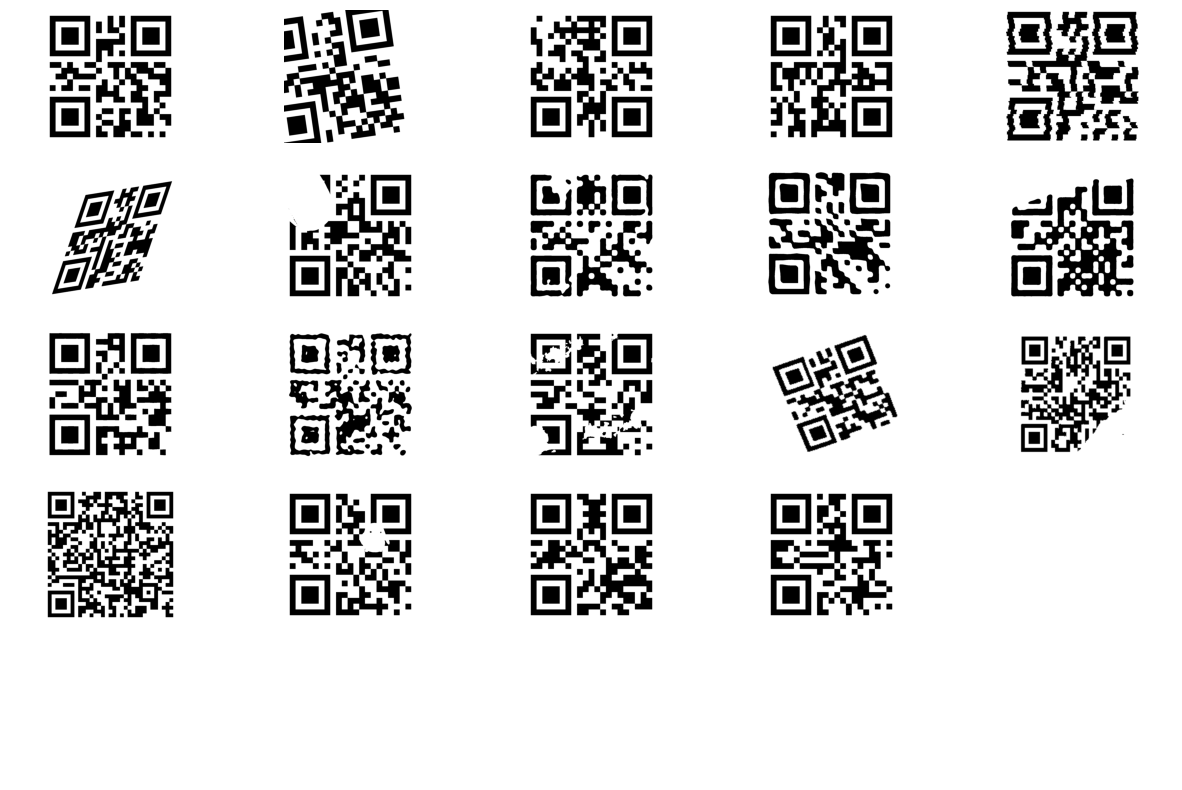

In [99]:
images_captured = []
for image in images_thresholded:
    image = capture(image)
    images_captured.append(image)
plot_all(images_captured)

## Tilt Correction ## 

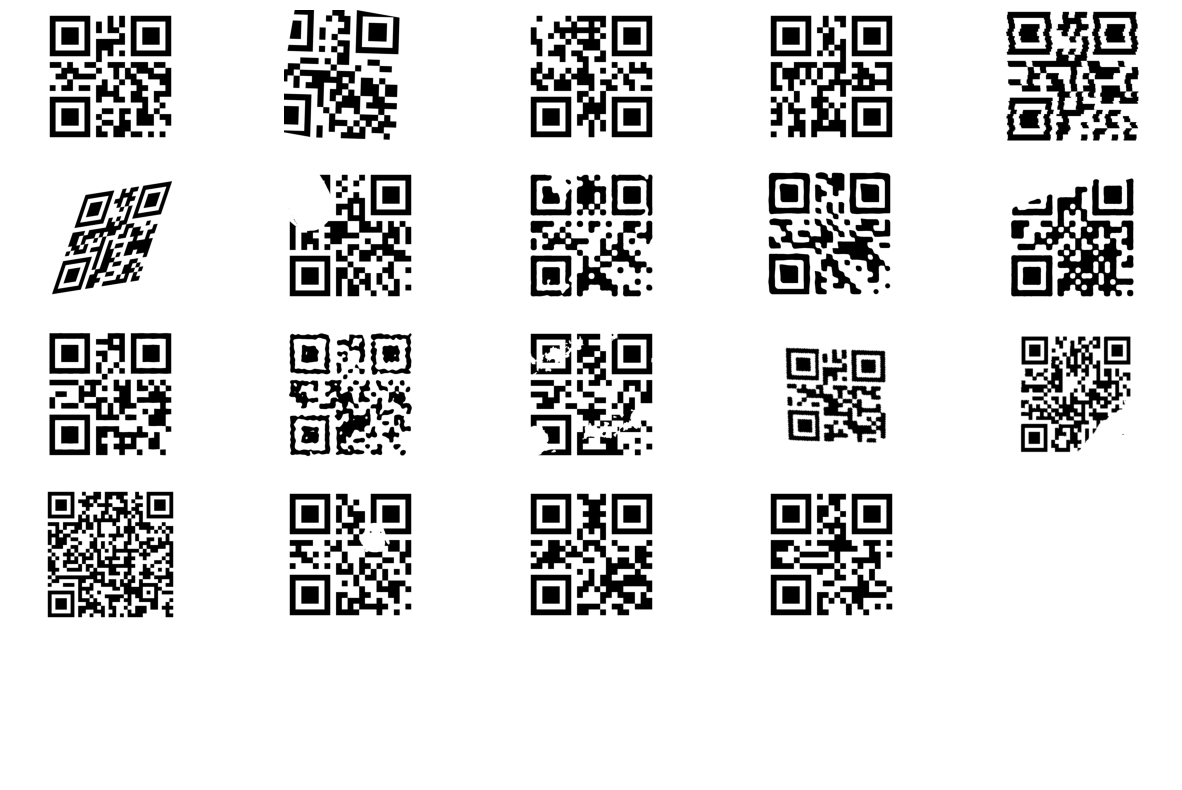

In [100]:
images_tilt_corrected = []
for image in images_captured:
    image = check_tilt(image)
    images_tilt_corrected.append(image)
plot_all(images_tilt_corrected)

## Detect QR code ##

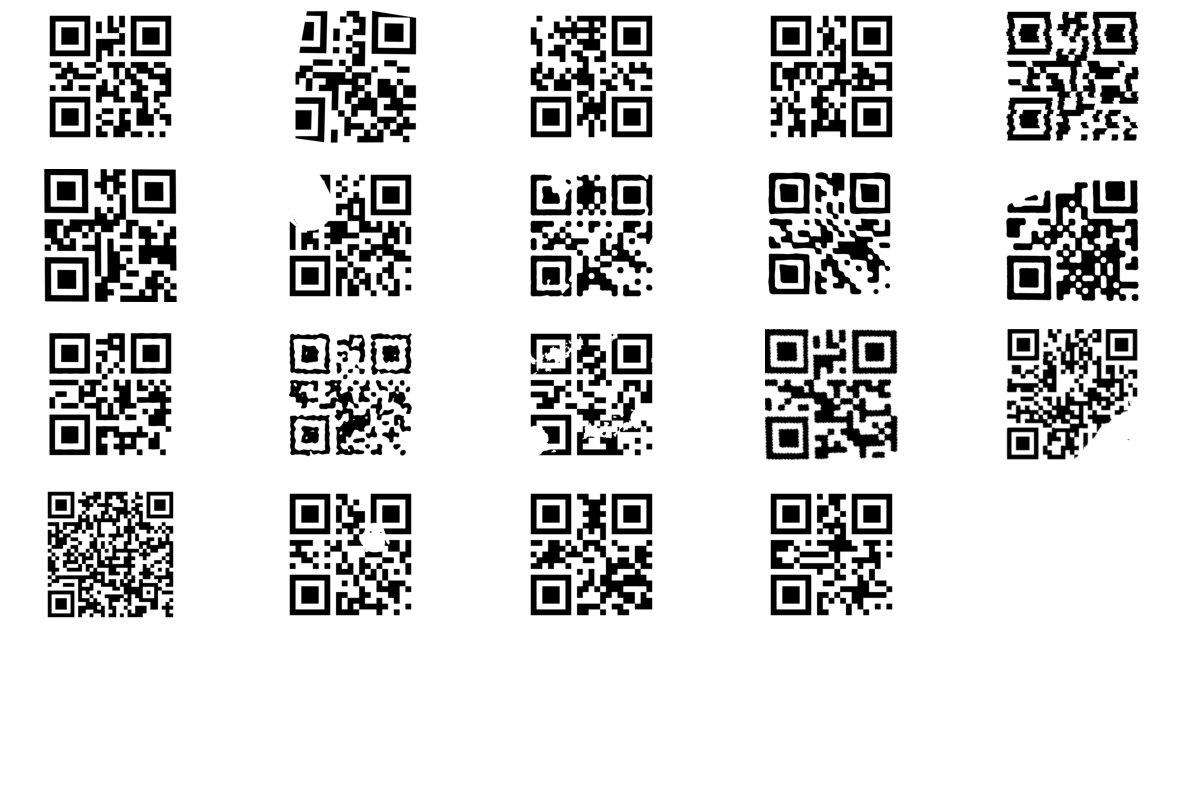

In [101]:
images_detected = []
for image in images_tilt_corrected:
    image = detect_qr_code(image)
    images_detected.append(image)
plot_all(images_detected)

# Decoding #

In [164]:
# Delete All text in decoded.txt
with open('decoded.txt', 'w') as f:
    f.write('')

images_decodable = images_detected[:14] + images_detected[16:]
for image in images_decodable:
    _, img = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    
    grid_cells_num = 21
    grid_cell_size = 50
    
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1
    
    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break
    
    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break
    
    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break
    
    
    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break
    
    
    top_border = min(start_row, max(start_col, img.shape[1] - end_col))
    bottom_border = min(img.shape[0] - end_row, max(start_col, img.shape[1] - end_col))
    left_border = min(start_col, max(start_row, img.shape[0] - end_row))
    right_border = min(img.shape[1] - end_col, max(start_row, img.shape[0] - end_row))
    
    qr_no_quiet_zone = img[top_border:img.shape[0] - bottom_border, left_border: img.shape[1] - right_border]
    qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (grid_cells_num * grid_cell_size, grid_cells_num * grid_cell_size), interpolation=cv2.INTER_AREA)
    
    # ...into grid cells
    qr_cells = qr_no_quiet_zone.reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)
    
    corrected_qr = correct_orientation(qr_no_quiet_zone, qr_cells, grid_cells_num, grid_cell_size)
    
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(corrected_qr):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    
    img_grid_inv = 1 - qr_cells_numeric

    ecl = img_grid_inv[grid_cells_num-2:grid_cells_num, 8]
    mask = img_grid_inv[grid_cells_num-3:grid_cells_num-6:-1, 8]
    
    MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
    }
    
    
    UP8, UP4, DOWN8, DOWN4, CW8, CCW8, UP_IRR, DOWN_IRR, CCW_IRR, UP_CORNER, DOWN_CORNER, UP_SKIP_TIM, DOWN_SKIP_TIM,\
    DOWN_SKIP_ALIGN, UP_ALIGN, CCW_SKIP_TIM, UP_SKIP_FORMAT  = range(17)
    
    fec = []
    fec.append(img_grid_inv[grid_cells_num-6, 8])
    fec.append(img_grid_inv[grid_cells_num-7, 8])
    fec.extend(img_grid_inv[8, grid_cells_num-8:grid_cells_num][::-1])
    fec = [int(c) for c in fec]
    
    format_info = [ecl, mask, fec]
    format_info = [bit for sub_format in format_info for bit in sub_format]
    
    fix_format_info(format_info)

    ecl = format_info[:2]
    mask = format_info[2:5]
    fec = format_info[5:]
    
    mask_str = ''.join([str(c) for c in mask])
    
    enc_bits = apply_mask_general(21-1, 21-1, img_grid_inv, mask, UP8)[:4]

    len_bits = apply_mask_general(21-3, 21-1, img_grid_inv, mask, UP8)
    len_int = int(''.join([str(bit) for bit in len_bits]), 2)
    
    v1_data_starting_indices = [
        [21-1,  21-1, UP4],
        [21-3,  21-1, UP8],
        [21-7,  21-1,  UP8],
        [21-11, 21-1,  CCW8],
        [21-10, 21-3,  DOWN8],
        [21-6,  21-3,  DOWN8],
        [21-2,  21-3,  CW8],
        [21-3,  21-5,  UP8],
        [21-7,  21-5,  UP8],
        [21-11, 21-5,  CCW8],
        [21-10, 21-7,  DOWN8],
        [21-6,  21-7,  DOWN8],
        [21-2,  21-7,  CW8],
        [21-3,  21-9,  UP8],
        [21-7,  21-9,  UP8],
        [21-11, 21-9,  UP8],
        [21-16, 21-9,  UP8],
        [21-20, 21-9,  CCW8],
        [21-19, 21-11, DOWN8],
        [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
        [21-12, 21-11, DOWN8],
        [21-8,  21-11, DOWN8],
        [21-4,  21-11, DOWN8],
        [21-9,  21-13, UP8],
        [21-12, 21-16, DOWN8],
        [21-9,  21-18, UP8],
        [21-12, 21-20, DOWN8],
    ]
    
    v3_data_starting_indices = []
    v4_data_starting_indices = []
    
    ALPHANUMERIC_TABLE = {
    
        0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
        5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    
        10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
        15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
        20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
        25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
        30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
        35: 'Z',
    
        36: ' ', 37: '$', 38: '%', 39: '*',
        40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
    }
    
    enc = apply_mask_general(grid_cells_num-1, grid_cells_num-1, img_grid_inv, mask,UP4)
    
    version = 1
    if version == 1:
      if enc == [0, 0, 1, 0]:
        decode_alphanumeric_v1()
      else:
        decode_byte_mode_v1()
    elif version == 3:
      decode_byte_mode_v3()
    elif version == 4:
      decode_byte_mode_v4()


This codec can correct up to 3 errors and 7 erasures independently
Data in message = "01-Good job!"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "02-Matsawar-3edel"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "LeffyBinaYaDonya"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "Black mirror hehe"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "|rxwx1eh2"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "dwXQ49gcwWQ"

Decoded string: THE MIGHTY FINGER
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "compressoespresso"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "mobiley we23 💀"
Data in message = "mobiley we23 ð"
This codec can correct up to 3 errors and 7 erasures independently
Data in message = "GoneWithTheWind"
This co